In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from time import gmtime, strftime, localtime
from matplotlib.ticker import MultipleLocator
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

params = {"xtick.direction": "in", "ytick.direction": "in"}
plt.rcParams.update(params)
plt.rcParams["font.family"] = "Tahoma"

C:\Users\gabriel\AppData\Local\Temp\ipykernel_26068\334190511.py:94: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  base_cmap = mpl.cm.get_cmap("tab20", len(Ecoregions))


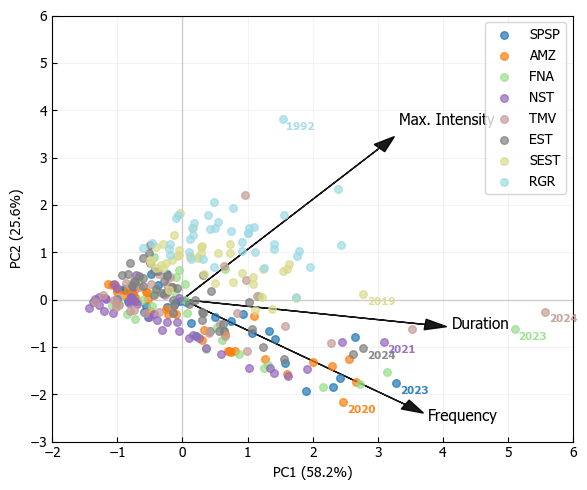

In [3]:
block_df = pd.read_csv('block_mhws_v202504.csv')

eco_map = {
    "Sao Pedro and Sao Paulo Islands": "SPSP",
    "Amazon": "AMZ",
    "Fernando de Noronha and Atol das Rocas": "FNA",
    "Northeastern Brazil": "NST",
    "Trindade and Martim Vaz Islands": "TMV",
    "Eastern Brazil": "EST",
    "Southeastern Brazil": "SEST",
    "Rio Grande": "RGR"
}

block_df["Ecoregion"] = block_df["Ecoregion"].replace(eco_map)


group_col = "Ecoregion"                     # or "Habitat"
features  = ["Number_of_MHWs", "Duration", "Maximum_intensity"]
mode      = "mean"                           # "mean" or "max"
missing   = "zero_if_no_events"              # "drop" | "zero_if_no_events" | "median"
label_years = False                          # annotate years
draw_trajectories = True                     # connect points per group

if mode == "mean":
    agg = block_df.groupby([group_col, "Year"], as_index=False)[features].mean()
elif mode == "max":
    agg = block_df.groupby([group_col, "Year"], as_index=False)[features].max()
else:
    raise ValueError("mode must be 'mean' or 'max'")

work = agg.copy()

if missing == "drop":
    work = work.dropna(subset=features)

elif missing == "zero_if_no_events":
    work["Number_of_MHWs"] = work["Number_of_MHWs"].fillna(0)
    zero_mask = work["Number_of_MHWs"] == 0
    for col in ["Duration", "Maximum_intensity"]:
        work.loc[zero_mask & work[col].isna(), col] = 0
    work = work.dropna(subset=features)

elif missing == "median":
    for col in features:
        med = work[col].median(skipna=True)
        work[col] = work[col].fillna(med)
else:
    raise ValueError("missing must be 'drop', 'zero_if_no_events', or 'median'")

if len(work) < 3:
    raise ValueError("Not enough non-NaN rows after aggregation/imputation to run PCA.")

X = work[features].to_numpy(dtype=float)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

pca = PCA(n_components=2)
scores = pca.fit_transform(X_scaled)
loadings = pca.components_.T * np.sqrt(pca.explained_variance_)

pc1_var = 100 * pca.explained_variance_ratio_[0]
pc2_var = 100 * pca.explained_variance_ratio_[1]

plot_df = work[[group_col, "Year"]].copy()
plot_df["PC1"] = scores[:, 0]
plot_df["PC2"] = scores[:, 1]
xrange = (-2, 6)
yrange = (-3, 6)

plot_df = plot_df.query("PC1 >= @xrange[0] and PC1 <= @xrange[1] and PC2 >= @yrange[0] and PC2 <= @yrange[1]")

group_col = "Ecoregion"

def make_abbrev(name, maxlen=4):
    toks = [t for t in str(name).replace("/", " ").replace("-", " ").split() if t]
    cand = "".join(w[0] for w in toks).upper()
    if not cand:
        cand = str(name)[:maxlen].upper()
    return cand[:maxlen]

Ecoregion_ORDER = ["SPSP", "AMZ", "FNA", "NST", "TMV", "EST", "SEST", "RGR"] 
if Ecoregion_ORDER is None:
    order_full = sorted(plot_df[group_col].dropna().unique().tolist())
else:
    order_full = [h for h in Ecoregion_ORDER if h in plot_df[group_col].unique()]

fig, ax = plt.subplots(figsize=(6, 5))

desired_order = ["SPSP", "AMZ", "FNA", "NST", "TMV", "EST", "SEST", "RGR"]
present = plot_df["Ecoregion"].unique().tolist()
Ecoregions = [h for h in desired_order if h in present] + [h for h in present if h not in desired_order]

import matplotlib as mpl
base_cmap = mpl.cm.get_cmap("tab20", len(Ecoregions))
colors = {h: mpl.colors.to_hex(base_cmap(i % base_cmap.N)) for i, h in enumerate(Ecoregions)}

markers = {h: "o" for h in Ecoregions}

for h in Ecoregions:
    sub = plot_df[plot_df["Ecoregion"] == h]
    ax.scatter(
        sub["PC1"], sub["PC2"],
        s=30,
        c=[colors[h]],
        marker=markers[h],
        label=h,
        alpha=0.7,
        zorder=2
    )

    sub_ext = sub.assign(pca_magnitude=np.hypot(sub["PC1"], sub["PC2"]))
    extreme = sub_ext.loc[sub_ext["pca_magnitude"].idxmax()]
    ax.text(
        extreme["PC1"] + 0.06,
        extreme["PC2"] - 0.06,
        str(int(extreme["Year"])),
        fontsize=8,
        color=colors[h],
        ha="left", va="top",
        weight="bold",
        alpha=0.9,
        zorder=3
    )

scores_radius = float(np.max(np.linalg.norm(scores[:, :2], axis=1)) or 1.0)
loads_radius  = float(np.max(np.linalg.norm(loadings[:, :2], axis=1)) or 1.0)
arrow_scale = 0.85 * scores_radius / loads_radius

label_map = {
    "Number_of_MHWs": "Frequency",
    "Duration": "Duration",
    "Maximum_intensity": "Max. Intensity"
}
for i, var in enumerate(features):
    x, y = loadings[i, 0]*arrow_scale, loadings[i, 1]*arrow_scale
    ax.arrow(0, 0, x, y, width=0.001, head_width=0.04*scores_radius,
             length_includes_head=True, color="k", alpha=0.9)
    ax.text(x*1.02, y*1.07, label_map.get(var, var), fontsize=11, color="k")

ax.axhline(0, color="lightgray", lw=1,zorder=0)
ax.axvline(0, color="lightgray", lw=1,zorder=0)
ax.set_xlabel(f"PC1 ({pc1_var:.1f}%)")
ax.set_ylabel(f"PC2 ({pc2_var:.1f}%)")
ax.grid(alpha=0.15)
ax.set_xlim(-2, 6)
ax.set_ylim(-3, 6) 

from matplotlib.lines import Line2D
legend_handles = [
    Line2D([0], [0], marker='o', linestyle='', markersize=7,
           markerfacecolor=colors[h], markeredgecolor='none') for h in Ecoregions
]
ax.legend(
    legend_handles, Ecoregions,
    title="Ecoregion", 
    loc="upper left",
    bbox_to_anchor=(1.02, 1),
    frameon=False,
    handlelength=1.0
)
ax.legend().set_visible(True)
plt.tight_layout()

#plt.savefig('new_figures/pca/ecoregion_w_leg.png',dpi=300)
plt.show()
